# Word2Vec (Skipgram )

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.26.4', '2.5.1+cu124')

In [3]:
import matplotlib
matplotlib.__version__

'3.10.0'

## 1. Load data

In [4]:
# Import The Reuters news Corpus from NLTK
# Data source: https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html
# Download Link in NLTK: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/reuters.zip 
import nltk
from nltk.corpus import reuters

# Define the training corpus
corpus = reuters.sents(categories="trade")

In [5]:
print("Length:", len(corpus))

Length: 4852


In [6]:
corpus

[['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.'], ['They', 'told', 'Reuter', 'correspondents', 'in', 'Asian', 'capitals', 'a', 'U', '.', 'S', '.', 'Move', 'against', 'Japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 'U', '.', 'S', '.', 'And', 'lead', 'to', 'curbs', 'on', 'American', 'imports', 'of', 'their', 'products', '.'], ...]

In [7]:
from nltk.corpus import stopwords
import string
import re

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Regular expression to match double punctuations
double_punctuation_pattern = re.compile(r'[' + re.escape(string.punctuation) + ']{2,}')

# Function to clean the corpus
def clean_corpus(corpus):
    cleaned_corpus = []
    for sentence in corpus:
        cleaned_sentence = []
        for word in sentence:
            word = word.lower()
            # Check for stopwords, punctuation, and double punctuation
            if word not in stop_words and word not in punctuation and not double_punctuation_pattern.match(word):
                cleaned_sentence.append(word)
        cleaned_corpus.append(cleaned_sentence)
    return cleaned_corpus

# Clean the corpus
corpus_tokenized = clean_corpus(corpus)
corpus_tokenized

[['asian',
  'exporters',
  'fear',
  'damage',
  'u',
  'japan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'u',
  'japan',
  'raised',
  'fears',
  'among',
  'many',
  'asia',
  'exporting',
  'nations',
  'row',
  'could',
  'inflict',
  'far',
  'reaching',
  'economic',
  'damage',
  'businessmen',
  'officials',
  'said'],
 ['told',
  'reuter',
  'correspondents',
  'asian',
  'capitals',
  'u',
  'move',
  'japan',
  'might',
  'boost',
  'protectionist',
  'sentiment',
  'u',
  'lead',
  'curbs',
  'american',
  'imports',
  'products'],
 ['exporters',
  'said',
  'conflict',
  'would',
  'hurt',
  'long',
  'run',
  'short',
  'term',
  'tokyo',
  'loss',
  'might',
  'gain'],
 ['u',
  'said',
  'impose',
  '300',
  'mln',
  'dlrs',
  'tariffs',
  'imports',
  'japanese',
  'electronics',
  'goods',
  'april',
  '17',
  'retaliation',
  'japan',
  'alleged',
  'failure',
  'stick',
  'pact',
  'sell',
  'semiconductors',
  'world',
  'markets',
  'cost'],
 ['unofficia

In [8]:
len(corpus_tokenized)

4852

In [9]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus_tokenized))) #all the words we have in the system - <UNK>

In [10]:
len(vocabs)

7135

In [11]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index

{'revenues': 0,
 'optimistically': 1,
 'patterns': 2,
 'intensification': 3,
 'derivatives': 4,
 '86': 5,
 'results': 6,
 'ticket': 7,
 '6075': 8,
 'warned': 9,
 'enactment': 10,
 'touching': 11,
 'expenditure': 12,
 'cts': 13,
 'provoke': 14,
 'approve': 15,
 'certificate': 16,
 'outflows': 17,
 'gaping': 18,
 'recommendations': 19,
 'moving': 20,
 'text': 21,
 'prompt': 22,
 'estimates': 23,
 'monitoring': 24,
 'employees': 25,
 'inaction': 26,
 'warns': 27,
 'deficits': 28,
 'exchange': 29,
 'publish': 30,
 'ec': 31,
 'totalling': 32,
 'shortfall': 33,
 'capacity': 34,
 'mikhail': 35,
 'effot': 36,
 'runs': 37,
 'ample': 38,
 'suppression': 39,
 'barclay': 40,
 'effectively': 41,
 'predict': 42,
 'mo': 43,
 'resembling': 44,
 'retain': 45,
 'preparatory': 46,
 'vitality': 47,
 '93': 48,
 'morony': 49,
 'aides': 50,
 'study': 51,
 'daub': 52,
 'communique': 53,
 'depressed': 54,
 'african': 55,
 'ore': 56,
 'cities': 57,
 'european': 58,
 'provincial': 59,
 'predicted': 60,
 'probabl

In [12]:
# append UNK
vocabs.append('<UNK>')
word2index['<UNK>'] = 7135

In [13]:
index2word = {v:k for k, v in word2index.items()}
index2word[7135]

'<UNK>'

In [14]:
len(word2index)

7136

## 2. Prepare train data

In [15]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus, window_size=2):
    skipgrams = []

    # Loop through each document in the corpus
    for doc in corpus:
        # Loop through each word in the document
        for i in range(len(doc)):
            # Center word
            center = word2index[doc[i]]
            
            # Outside words: dynamically determine the window based on window_size
            outside_indices = []
            for j in range(1, window_size + 1):
                # Left context
                if i - j >= 0:
                    outside_indices.append(word2index[doc[i - j]])
                # Right context
                if i + j < len(doc):
                    outside_indices.append(word2index[doc[i + j]])
            
            # For each outside word, create a (center, outside) pair
            for each_out in outside_indices:
                skipgrams.append([center, each_out])
    
    # Randomly sample `batch_size` skip-grams
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    # Prepare inputs and labels
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])  # Center word
        labels.append([skipgrams[index][1]])  # Outside word
    
    return np.array(inputs), np.array(labels)           


In [16]:
x, y = random_batch(2, corpus_tokenized, 2)

In [17]:
x.shape  #batch_size, 1

(2, 1)

In [18]:
x

array([[5355],
       [4033]])

In [19]:
y.shape  #batch_size 1

(2, 1)

In [20]:
print("Inputs (center words):", x)
print("Labels (outside words):", y)

Inputs (center words): [[5355]
 [4033]]
Labels (outside words): [[4033]
 [4972]]


## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [21]:
len(vocabs)

7136

In [22]:
embedding = nn.Embedding(7136, 2)

In [23]:
x_tensor = torch.LongTensor(x)
embedding(x_tensor).shape  #(batch_size, 1, emb_size)

torch.Size([2, 1, 2])

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [24]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_outside(outside) #(batch_size, window_size, emb_size)
        all_vocabs_embedding = self.embedding_outside(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        # (batch_size, window_size)

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        # (batch_size, voc_size)
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss
        

In [25]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[   0,    1,    2,  ..., 7133, 7134, 7135],
        [   0,    1,    2,  ..., 7133, 7134, 7135]])

In [26]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(7136, 2)
  (embedding_outside): Embedding(7136, 2)
)

In [27]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [28]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [29]:
loss

tensor(10.1560, grad_fn=<NegBackward0>)

## 4. Training

In [30]:
# Check if CUDA is available and use GPU if yes
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
else:
    device = torch.device("cpu")   # Use CPU

In [31]:
import time


#calculate epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time // 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
# Set Training Parameters
window_size= 5
batch_size = 256
emb_size   = 50
voc_size = len(vocabs)
all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size).to(device)

model      = Skipgram(voc_size, emb_size).to(device)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [33]:
num_epochs = 1000
start = time.time()

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized, window_size)
    input_tensor = torch.LongTensor(input_batch).to(device)
    label_tensor = torch.LongTensor(label_batch).to(device)
    
    #predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 100 == 0:
        end = time.time()
        epoch_mins, epoch_secs = epoch_time(start, end)

        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch    100 | Loss: 25.306461 | time: 1m 3s
Epoch    200 | Loss: 24.270130 | time: 2m 8s
Epoch    300 | Loss: 22.674711 | time: 3m 12s
Epoch    400 | Loss: 21.928768 | time: 4m 14s
Epoch    500 | Loss: 21.144691 | time: 5m 17s
Epoch    600 | Loss: 21.260284 | time: 6m 20s
Epoch    700 | Loss: 19.388655 | time: 7m 23s
Epoch    800 | Loss: 18.584747 | time: 8m 26s
Epoch    900 | Loss: 18.101543 | time: 9m 29s
Epoch   1000 | Loss: 17.670746 | time: 10m 32s


**Total training time for Word2Vec (Skipgram) is 10 minutes 33 seconds**

## 5. Plot the embeddings

In [34]:
len(vocabs)

7136

In [35]:
vocabs[:20]

['revenues',
 'optimistically',
 'patterns',
 'intensification',
 'derivatives',
 '86',
 'results',
 'ticket',
 '6075',
 'warned',
 'enactment',
 'touching',
 'expenditure',
 'cts',
 'provoke',
 'approve',
 'certificate',
 'outflows',
 'gaping',
 'recommendations']

In [36]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]]).to(device)
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

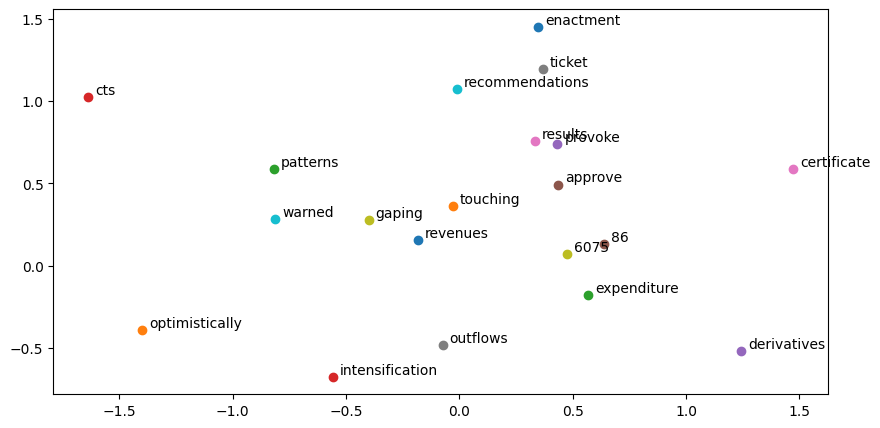

In [37]:
plt.figure(figsize=(10, 5))
for i, word in enumerate(vocabs[:20]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [39]:
#save the GloVe model with pickle
import pickle

pickle.dump(model, open('../../models/Word2Vec(Skipgram).model', 'wb'))

In [40]:
#save the GloVe model with torch
torch.save(model.state_dict(), '../../models/Word2Vec(Skipgram.pt)')

In [41]:
Data = {
    'corpus': corpus_tokenized,
    'vocab': vocabs,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': emb_size,
    'window_size': window_size
}

In [ ]:
# Save Data
pickle.dump(Data,open('../../models/Data.pkl', 'wb'))

: 